# Лабораторная работа №6
## Синтезатор частот и ФАПЧ
### Звягин М.

Добавление используемых библиотек

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

### Фазовый детектор

In [ ]:
def Phase_Detector_Direct(input_sample, nco_sample, K_pd):
    phase_error = np.angle(input_sample*np.conjugate(nco_sample))
    return K_pd*phase_error

In [ ]:
fs = 1e5
Ts = 1/fs
f1 = 1e3
f2 = 1.1e3
K_pd = 1

t = np.arange(0, 2000)/fs
s_1 = np.exp(1j*(2*np.pi*f1*t))
s_2 = np.exp(1j*(2*np.pi*f2*t))

s_res_2 = np.zeros(shape=np.shape(s_1))
s = np.zeros(shape=np.shape(s_1))
for i in np.arange(0, len(s_1)):
    input_tmp = np.atan2(np.imag(s_2[i]), np.real(s_2[i]))
    s_res_2[i] = Phase_Detector_Direct(s_1[i], s_2[i], K_pd)
    s[i] = (s_1[i]*s_2[i])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t*1e3, s_1, label = 'Первый входной сигнал')
plt.plot(t*1e3, s_2, label = 'Второй входной сигнал')
plt.title('Сигналы на входе фазового детектора')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t*1e3, s_res_2, '--', label = 'Выход фазового детектора')
plt.plot(t*1e3, np.real(s_1*np.conjugate(s_2)), '--', label = 'Реальная часть от комплексного произведения')
plt.plot(t*1e3, np.imag(s_1*np.conjugate(s_2)), '--', label = 'Мнимая часть от комплексного произведения')
plt.title('Сигнал на выходе фазового детектора')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()
plt.tight_layout()


В предположении, что при стабильной работе ФАПЧ фазовая ошибка стремится к 0 и находится вблизи нуля, можно рассматривать его линейную версию, то есть считать, что на выходе фазового детектора получается непосредственная разность фаз, а не функция, зависящая от разности фаз

$$\sin(x) → x$$

Для данной реализации коэффициент фазового детектора всегда должен составлять $K_{PD} = 1$

### Петлевой фильтр

В качестве петлевого фильтра выбран пропорционально-интегрирующий фильтр, как самый часто используемый тип фильтров для ФАПЧ.

Основной задачей петлевого фильтра является формирование правильного управляющего сигнала на NCO и обеспечение динамических характеристик петли.

Основные коэффициенты данного фильтра:
1) Пропорциональный коэффициент $K_P$ - определяет пропорциональную составляющую сигнала, которая зависит от текущего входного отсчета
$$e_{F,1}[n] = K_P \cdot e_D[n]$$

2) Интегральный коэффициент $K_I$ - определяет интегральную составляющую сигнала, которая зависит от текущего и предыдущих входных отсчетов. Данный компонент приближает к нулю ошибку ФАПЧ при установлении синхронизации.
$$e_{F,2}[n] = e_{F,2}[n-1] + K_i \cdot e_D[n]$$

Выход фильтра:
$$e_F[n] = e_{F,1}[n] + e_{F,2}[n]$$

Далее будет рассмотрено, как вычисляются данные коэффициенты. Их значения будут зависеть от выбранных значений коэффициента демпфирования и собственной частоты контура

In [ ]:
def Phase_Unwrap_LP(phase):
    while (phase > 2*np.pi):
        phase -= 2*np.pi
    while (phase < -2*np.pi):
        phase += 2*np.pi
    return phase

class Loop_Filter:
    # Конструктор класса
    def __init__(self, fs, K_pd, K_nco):
        self.integral_part = 0
        self.damping_factor = np.sqrt(2)/2
        self.natural_freq = 2*np.pi*fs/100
        self.equivalent_noise_bandwidth = self.natural_freq/2*(self.damping_factor + 1/(4*self.damping_factor))
        
        self.K_p = 1/(K_pd*K_nco)*(4*self.damping_factor/(self.damping_factor + 1/(4*self.damping_factor)))*self.equivalent_noise_bandwidth/fs
        self.K_i = 1/(K_pd*K_nco)*(4/(self.damping_factor + 1/(4*self.damping_factor))**2)*(self.equivalent_noise_bandwidth/fs)**2
    
    # Функция для обновления полосы попускания
    def update_equivalent_noise_bandwidth(self):
        self.equivalent_noise_bandwidth = self.natural_freq/2*(self.damping_factor + 1/(4*self.damping_factor))
        
    # Функция для обновления параметров
    def update_loop_factors(self, fs, K_pd, K_nco):        
        self.K_p = 1/(K_pd*K_nco)*(4*self.damping_factor/(self.damping_factor + 1/(4*self.damping_factor)))*self.equivalent_noise_bandwidth/fs
        self.K_i = 1/(K_pd*K_nco)*(4/(self.damping_factor + 1/(4*self.damping_factor))**2)*(self.equivalent_noise_bandwidth/fs)**2
        
    # Функции для установки параметров
    def set_damping_factor(self, damping_factor):
        self.damping_factor = damping_factor
        
    def set_natural_freq(self, natural_freq):
        self.natural_freq = natural_freq

    def set_equivalent_noise_bandwidth(self, equivalent_noise_bandwidth):
        self.equivalent_noise_bandwidth = equivalent_noise_bandwidth
        
    # Функции для получения параметров
    def get_damping_factor(self):
        return self.damping_factor
    
    def get_natural_freq(self):
        return self.natural_freq  
    
    def get_equivalent_noise_bandwidth(self):
        return self.equivalent_noise_bandwidth      
    
    def get_K_p(self):    
        return self.K_p
    
    def get_K_i(self):
        return self.K_i

    # Основная функция вызова
    def __call__(self, error_sample):
        proportional_part = self.K_p*error_sample
        self.integral_part += self.K_i*error_sample
        return proportional_part + self.integral_part, self.integral_part

In [ ]:
fs = 1e6
Ts = 1/fs
f = 1e3

t = np.arange(0, 10*fs/f)/fs
s = np.cos(2*np.pi*f*t)

LP = Loop_Filter(fs, 1, 1)

LP_out = np.zeros(shape=np.shape(s))
LP_integral = np.zeros(shape=np.shape(s))
for i in np.arange(0, len(s)):
    LP_out[i], LP_integral[i] = LP(s[i])

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(s)
plt.title('Сигнал на входе петлевого фильтра')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(LP_out, '-')
plt.title('Сигнал на выходе петлевого фильтра')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(LP_integral)
plt.title('Интегральная составляющая сигнала на выходе петлевого фильтра')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()
plt.tight_layout()

### NCO

In [1]:
class NCO:
    def __init__(self):
        self.phase = 0
        self.delta_phase_NCO = 0
        self.K_nco = 1
    
    def set_freq(self, freq_nco, fs):
        self.delta_phase_NCO = 2*np.pi*freq_nco/fs            
    
    def set_factor(self, factor):
        self.K_nco = factor
              
    def get_freq(self):
        return self.delta_phase_NCO

    def get_factor(self):
        return self.K_nco
    
    def update_phase(self, delta_phase_LP):
        self.phase += self.K_nco*delta_phase_LP + self.delta_phase_NCO
        
    def __call__(self, delta_phase_LP):
        
        self.update_phase(delta_phase_LP)
        return np.exp(1j*self.phase), self.phase

C:\Users\Misha\AppData\Local\Temp\ipykernel_13880\2697010303.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Misha\AppData\Local\Temp\ipykernel_13880\2697010303.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Misha\AppData\Local\Temp\ipykernel_13880\2697010303.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


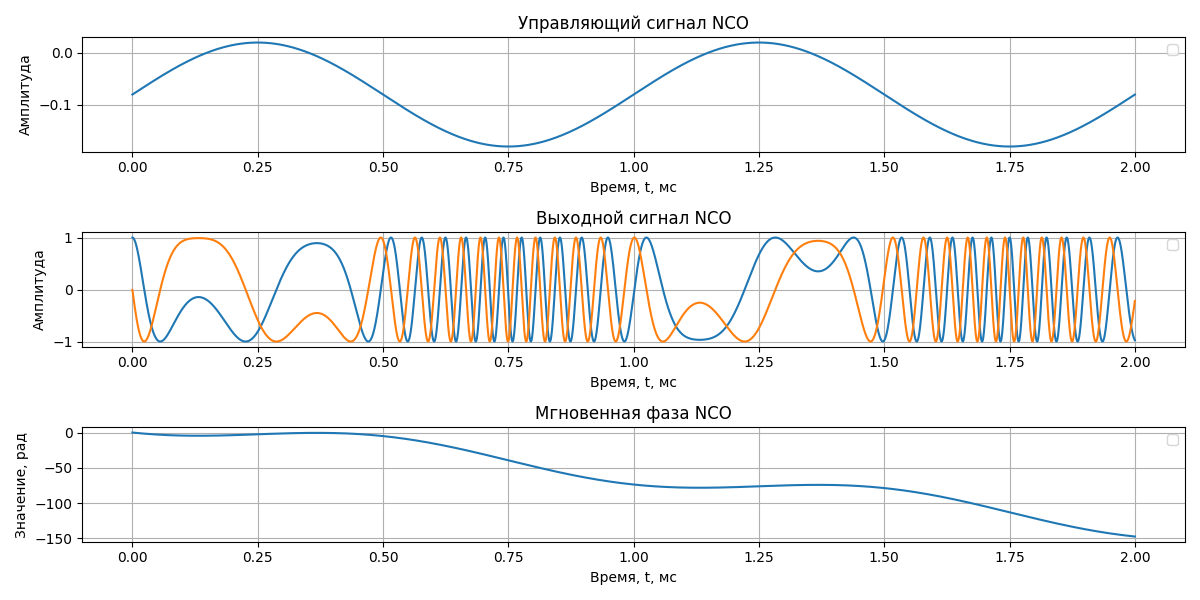

In [4]:
fs = 1e7
Ts = 1/fs
f = 1000

t = np.arange(0, 2*fs/f)/fs
s = 0.1*(-0.8 + np.sin(2*np.pi*f*t))


nco = NCO()
nco.set_freq(1000, fs)
nco.set_factor(0.1)

s_res = np.zeros(shape=np.shape(s), dtype=complex)
s_phase = np.zeros(shape=np.shape(s))
for i in np.arange(0, len(s)):
    s_res[i], s_phase[i] = nco(s[i])

plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(t*1e3, s)
plt.title('Управляющий сигнал NCO')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t*1e3, np.real(s_res))
plt.plot(t*1e3, np.imag(s_res))
plt.title('Выходной сигнал NCO')
plt.ylabel('Амплитуда')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t*1e3, s_phase)
plt.title('Мгновенная фаза NCO')
plt.ylabel('Значение, рад')
plt.xlabel('Время, t, мс')
plt.grid()
plt.legend()
plt.tight_layout()

### ФАПЧ

Схема ФАПЧ состоит из замкнутой цепи, состоящей из 
1) **Фазового детектора**, на входы которого поступают локально сгенерированный сигнал с ГУН и внешний сигнал
2) **Петлевого фильтра**, который преобразует сигнал после фазового детектора в управляющий сигнал для ГУН
3) **ГУН**, который генерирует локальный сигнал на основе управляющего сигнала с петлевого фильтра

In [ ]:
fs = 1e6
Ts = 1/fs
f_vco = 2000 # Начальная частота ГУН
f_sig = f_vco + 1000 # Частота входного сигнала
K_pd = 1 # Коэффициент усиления фазового детектора
K_nco = 1 # Коэффициент NCO

LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(np.sqrt(2)/2)
LP.set_natural_freq(2*np.pi*fs/5000)
LP.update_equivalent_noise_bandwidth()
LP.update_loop_factors(fs, K_pd, K_nco)

nco = NCO()
nco.set_freq(f_vco, fs)
nco.set_factor(K_nco)


t = np.arange(0, 50*fs/f_sig)/fs
signal_input = np.exp(1j*(2*np.pi*f_sig*t))

phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
loop_filter_integral_part = np.zeros((np.shape(signal_input)))
loop_filter_out = np.zeros((np.shape(signal_input)))

nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
nco_phase = np.zeros((np.shape(signal_input)))

signal_error = np.zeros((np.shape(signal_input)))
signal_out = np.zeros((np.shape(signal_input)))


for i in np.arange(1, len(signal_input)):
    nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
    
    signal_out[i] = np.real(nco_out[i])
    signal_error[i] = signal_input[i] - signal_out[i]
    
    phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
    loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    
plt.figure(figsize=(10,10))
plt.subplot(5, 1, 4)
plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
plt.title('Ошибка ФАПЧ')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()
 
plt.subplot(5, 1, 1)
plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
plt.title('Выход фазового детектора')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
plt.title('Выход петлевого фильтра')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
plt.title('Сравнение входного и выходного сигналов')
plt.xlabel('Время t, мкс ')
plt.grid()
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
plt.title('Частота ГУН')
plt.xlabel('Время t, мкс ')
plt.grid()
plt.legend()
plt.tight_layout()


Полученные результаты доказывают корректность работы схемы ФАПЧ

### Зависимости

В данном блоке путем моделирования попытаемся определить, как изменение различных параметров схемы ФАПЧ влияет на ее работу

#### АЧХ ФАПЧ и влияение на нее коэффициентов демпфирования и собственной частоты петлевого фильтра

In [ ]:
w = np.logspace(0, 5, 10000)
w_natural = 2*np.pi*500
demp_factor = np.sqrt(2)/2

H = (2*demp_factor*w_natural*(1j * w) + w_natural**2)/((1j * w)**2 + 2*demp_factor*w_natural*(1j * w) +  w_natural**2)
magnitude = np.abs(H) 
phase = np.angle(H, deg=True)

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.semilogx(w/w_natural, 20 * np.log10(magnitude))
plt.title('АЧХ ФАПЧ')
plt.xlabel('Относительная частота, 1/w_natural')
plt.ylabel('Уровень, дБ')
plt.grid(which='both', linestyle='--', linewidth=0.7)

plt.subplot(2, 1, 2)
plt.semilogx(w/w_natural, phase)
plt.title('Фазовая характеристика ФАПЧ')
plt.xlabel('Относительная частота, 1/w_natural')
plt.ylabel('Фаза, градусы')
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()



По построенной АЧХ для ФАПЧ можно сделать вывод, что он представляет собой некий ФНЧ, у которого рабочая полоса частот находится в диапазоне от 0 до w_natural (собственная частота петлевого фильтра).
Это значит, что система ФАПЧ способна отслеживать и подстраивать частоту ГУН по частооту входного сигнала, если их разность лежит в рабочей полосе. Таким образом, выбор значения собственной частоты петлевого фильтра определяет, размер полосы, в которой будет работать ФАПЧ

In [ ]:
w = np.logspace(0, 5, 10000)
w_natural = 2*np.pi*500
demp_factor = np.linspace(0.1, 2, 5)

plt.figure(figsize=(10, 6))
for d_f in demp_factor:
    H = (2*d_f*w_natural*(1j * w) + w_natural**2)/((1j * w)**2 + 2*d_f*w_natural*(1j * w) +  w_natural**2)
    magnitude = np.abs(H) 
    phase = np.angle(H, deg=True)

    plt.subplot(2, 1, 1)
    plt.semilogx(w/w_natural, 20 * np.log10(magnitude), label = f'demp_factor = {d_f}')
    plt.title(f'АЧХ ФАПЧ при demp_factor = {d_f}')
    plt.xlabel('Относительная частота, 1/w_natural')
    plt.ylabel('Уровень, дБ')
    plt.grid(which='both', linestyle='--', linewidth=0.7)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.semilogx(w/w_natural, phase)
    plt.title('Фазовая характеристика ФАПЧ при demp_factor = {d_f}')
    plt.xlabel('Относительная частота, 1/w_natural')
    plt.ylabel('Фаза, градусы')
    plt.grid(True, which='both', linestyle='--')
    plt.legend()
    plt.tight_layout()

По полученным графикам можно заключить, что при увеличении значения демпфинг фактора немного увеличивается полоса пропускания ФАПЧ.

Формула для определения рабочей полосы ФАПЧ:
$$B_n = \frac{\omega_n}{2} \left( \zeta + \frac{1}{4\zeta}\right)$$

#### Работа ФАПЧ при фиксированной собственной частоте и с различными частотами входного сигнала

In [ ]:
def PLL(fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw,  number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    

    t = np.arange(0, number_periods*fs/f_sig)/fs
    signal_input = np.exp(1j*(2*np.pi*f_sig*t + p_sig))

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
        
        signal_out[i] = np.real(nco_out[i])
        signal_error[i] = signal_input[i] - signal_out[i]
        
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(5, 1, 4)
        plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
        plt.title('Ошибка ФАПЧ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. Исходная разность частот {np.abs(f_vco - f_sig)}')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()


В литературе предлагается устанавливать полосу пропускания ФАПЧ на значение от 1% до 5% от fs

In [ ]:
fs = 1e6
f_vco = 2e3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = 0.001

number_periods = 500
visible = True

LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_natural_freq(2*np.pi*fs/freq_nat)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

f_sig = f_vco + np.linspace(0, 2*np.pi*LP.get_equivalent_noise_bandwidth() + 2e3, 15)
p_sig = np.pi/3

for freq_signal in f_sig:
    PLL(fs, f_vco, freq_signal, p_sig, K_pd, K_nco, freq_nat, demp_factor, factor_bw, number_periods, visible)

По полученным результатам видно, что при установленном значении ширины полосы пропускания ФАПЧ (~6200 Гц) система смогла подстроиться под частоту входного сигнала с максимальным отклонением примерно 7700 Гц, что выше установленной ширины полосы на 1500 Гц. Скорее всего, данное явление связано с влиянием демпфирующего фактора и тем, что на АЧХ ФАПЧ после установленной ширины есть небольшой запас до начала резкого спада. 

Таким образом, для данного моделирования значение полосы захвата составялет примерно 7700 Гц.

In [ ]:
fs = 1e6
f_vco = 2e3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = 0.0001

number_periods = 500
visible = True

LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_natural_freq(2*np.pi*fs/freq_nat)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

f_sig = f_vco + np.linspace(0, 2*np.pi*LP.get_equivalent_noise_bandwidth() + 1e2, 10)
p_sig = np.pi/3

for freq_signal in f_sig:
    PLL(fs, f_vco, freq_signal, p_sig, K_pd, K_nco, freq_nat, demp_factor, factor_bw, number_periods, visible)

Проведено аналогичное моделирование с меньшей полосой пропускания.

По полученным результатам видно, что при установленном значении ширины полосы пропускания ФАПЧ (~620 Гц) система смогла подстроиться под частоту входного сигнала с максимальным отклонением примерно 500 Гц, что ниже установленной ширины полосы на 120 Гц. Полученный результат не совсем соотвествтует предыдущему моделированию, но также показывает, что на рабочую полосу частот влияет не только установленное значение полосы частот (непосредственно в моделировании работы системы участвуют пропорциональный и интегральный коэффициенты петлевого фильтра, которые рассчитываются исходя из установленного значения демпфинг фактора и полосы пропускания). Возможно, в данном случае значение демпфинг фактора так повлияло на работу ФАПЧ (то есть он может как увеличивать, так и уменьшать реальную рабочую полосу).

Таким образом, для данного моделирования значение полосы захвата составялет примерно 500 Гц.

#### Работа ФАПЧ при фиксированном входном сигнале, демпфинг фактору и разных значениях полосы пропускания

In [ ]:
def PLL(fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw,  number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    

    t = np.arange(0, number_periods*fs/f_sig)/fs
    signal_input = np.exp(1j*(2*np.pi*f_sig*t + p_sig))

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
        
        signal_out[i] = np.real(nco_out[i])
        signal_error[i] = signal_input[i] - signal_out[i]
        
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(5, 1, 4)
        plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
        plt.title('Ошибка ФАПЧ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. Исходная разность частот {np.abs(f_vco - f_sig)}. Заданная полоса пропускания {2*np.pi*factor_bw*fs}')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()


In [ ]:
fs = 1e6
f_vco = 2e3
f_sig = f_vco + 500
p_sig = np.pi/3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = np.arange(1, 5)*1e-4

number_periods = 500
visible = True

for f_bw in factor_bw:
    PLL(fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, demp_factor, f_bw, number_periods, visible)

По результатам данного моделирования можно сделать вывод, что увеличение полосы пропускания ФАПЧ позволяет быстрее захватить входной сигнал, если исходная разность частот находится в заданной полосе.

При данном моделировании нет зависимости ошибки ФАПЧ в установившемся состоянии от значения полосы поропускания. Скорее всего, это связано с тем, что на вход подается идеальный (незашумленный сигнал).

#### Работа ФАПЧ при фиксированном входном сигнале, полосе пропускания и разных значениях демпфинг фактора

In [ ]:
def PLL(fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw,  number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    

    t = np.arange(0, number_periods*fs/f_sig)/fs
    signal_input = np.exp(1j*(2*np.pi*f_sig*t + p_sig))

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
        
        signal_out[i] = np.real(nco_out[i])
        signal_error[i] = signal_input[i] - signal_out[i]
        
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(5, 1, 4)
        plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
        plt.title('Ошибка ФАПЧ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. Исходная разность частот {np.abs(f_vco - f_sig)}. Демпфинг фактор {demp_factor}')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()


In [ ]:
fs = 1e6
f_vco = 2e3
f_sig = f_vco + 3000
p_sig = np.pi/3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = np.arange(1, 10)/10
factor_bw = 0.001

number_periods = 500
visible = True

LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_natural_freq(2*np.pi*fs/freq_nat)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

for d_f in demp_factor:
    PLL(fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, d_f, factor_bw, number_periods, visible)

По полученным графикам можно сделать вывод, что увеличение значения демпфинг фактора (до 1) позволяет ФАПЧ быстрее захватить сигнал и подстроить частоту. При сильно низком значении (0,1) ФАПЧ не смог синхронизироваться вообще.

В данном моделировании не было никакой зависимости значения ошибки ФАПЧ после установления от демпфинг фактора. Скорее всего это связано с тем, что на вход подаются идеальные (без шума) сигналы и также в ФАПЧ не предусмотрено добавление каких-либо дополнительных неидеальностей (тепловой шум отдельных блоков, джиттер им тд.)

#### Определение полосы удержания

В предыдущих моделированиях была опеределена полоса захвата, то есть максимальное значение разности частот входного сигнала и локального сигнала с ГУН с его начальной частотой, при которой ФАПЧ смогла захватить синал и подстроиться

Полоса удержания - это максимальное значение частоты рассогласования, при которой синхронизированная система ФАПЧ остается в режиме слежения, то есть не теряет синхронизацию.

Для данного моделирования в качестве входного сигнала сгенерируем ЛЧМ сигнал.

In [ ]:
fs = 1e6
Ts = 1/fs
f_vco = 2000 # Начальная частота ГУН
K_pd = 1 # Коэффициент усиления фазового детектора
K_nco = 1 # Коэффициент NCO
factor_bw = 0.001
demp_factor = 0.5

f_start = f_vco
f_end = f_vco + 1000
T = 50/f_vco
t = np.arange(0, T, 1/fs)
k = (f_end - f_start) / T

phi = 2 * np.pi * (f_start * t + 0.5 * k * t**2)
signal_input = np.exp(1j * phi)


LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

nco = NCO()
nco.set_freq(f_vco, fs)
nco.set_factor(K_nco)

phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
loop_filter_integral_part = np.zeros((np.shape(signal_input)))
loop_filter_out = np.zeros((np.shape(signal_input)))

nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
nco_phase = np.zeros((np.shape(signal_input)))

signal_error = np.zeros((np.shape(signal_input)))
signal_out = np.zeros((np.shape(signal_input)))



for i in np.arange(1, len(signal_input)):
    nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
    
    signal_out[i] = np.real(nco_out[i])
    signal_error[i] = signal_input[i] - signal_out[i]
    
    phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
    loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])

plt.figure(figsize=(10,10))
plt.subplot(5, 1, 4)
plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
plt.title('Ошибка ФАПЧ')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 1)
plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
plt.title('Выход фазового детектора')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
plt.title('Выход петлевого фильтра')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
plt.title('Сравнение входного и выходного сигналов')
plt.xlabel('Время t, мкс ')
plt.grid()
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
plt.title('Частота ГУН')
plt.xlabel('Время t, мкс ')
plt.grid()
plt.legend()
plt.tight_layout()



По полученным результатам видно, что ФАПЧ не только синхронизирует сигнал, но и удерживает синхронизацию при небольшом изменении частоты входного сигнала.

Было решено не вставлять полученные графики, однако в результате моделирований был сделан вывод, что полоса удержания ФАПЧ в первую очередь зависит от скорости изменения входного сигнала (если изменение частоты достаточно маленькое, то система ФАПЧ всегда будет удерживать сигнал, в предположении идеальной математической версии). При увеличении скорости изменения частоты входного сигнала в удержании ФАПЧ основную роль будет игррать скорость подстройки, так как ФАПЧ должен успевать изменять локальную частоту ГУН.

Ниже приведен пример моделирования, когда скорость изменения сигнала выставлена большой, чтобы ФАПЧ не мог удержать сигнал

In [ ]:
fs = 1e6
Ts = 1/fs
f_vco = 2000 # Начальная частота ГУН
K_pd = 1 # Коэффициент усиления фазового детектора
K_nco = 1 # Коэффициент NCO
factor_bw = 0.001
demp_factor = 0.5

f_start = f_vco
f_end = f_vco + 10000
T = 20/f_vco
t = np.arange(0, T, 1/fs)
k = (f_end - f_start) / T

phi = 2 * np.pi * (f_start * t + 0.5 * k * t**2)
signal_input = np.exp(1j * phi)


LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

nco = NCO()
nco.set_freq(f_vco, fs)
nco.set_factor(K_nco)

phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
loop_filter_integral_part = np.zeros((np.shape(signal_input)))
loop_filter_out = np.zeros((np.shape(signal_input)))

nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
nco_phase = np.zeros((np.shape(signal_input)))

signal_error = np.zeros((np.shape(signal_input)))
signal_out = np.zeros((np.shape(signal_input)))



for i in np.arange(1, len(signal_input)):
    nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
    
    signal_out[i] = np.real(nco_out[i])
    signal_error[i] = signal_input[i] - signal_out[i]
    
    phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
    loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])

plt.figure(figsize=(10,10))
plt.subplot(5, 1, 4)
plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
plt.title('Ошибка ФАПЧ')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 1)
plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
plt.title('Выход фазового детектора')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
plt.title('Выход петлевого фильтра')
plt.xlabel('Время t, мкс ')
plt.ylabel('Амплитуда')
plt.grid()
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
plt.title('Сравнение входного и выходного сигналов')
plt.xlabel('Время t, мкс ')
plt.grid()
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
plt.title('Частота ГУН')
plt.xlabel('Время t, мкс ')
plt.grid()
plt.legend()
plt.tight_layout()



Видно, что ФАПЧ пытается подстроиться, но скорость изменения частоты входного сигнала настолько большая, что сигнал с выхода ФАПЧ немнго "отстает".

#### Влияние АБГШ на работу ФАПЧ

Для данного моделирования к входному сигналу добавим АБГШ заданной мощности.

In [ ]:
def add_awgn(signal, SNR):
    power_signal_linear = np.sum(np.abs(signal)**2)/signal.size
    power_noise = power_signal_linear/(10**(SNR/10))
    noise = np.sqrt(power_noise / 2) * (np.random.randn(len(signal)) + 1j*np.random.randn(len(signal)))
    return signal + noise

In [ ]:
def PLL(fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr, number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    t = np.arange(0, number_periods*fs/f_sig)/fs
    signal_input = add_awgn(np.exp(1j*(2*np.pi*f_sig*t + p_sig)), snr)

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
        
        signal_out[i] = np.real(nco_out[i])
        signal_error[i] = signal_input[i] - signal_out[i]
        
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(5, 1, 4)
        plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
        plt.title('Ошибка ФАПЧ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. Исходная разность частот {np.abs(f_vco - f_sig)}. ОСШ = {snr} дБ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()


In [ ]:
fs = 1e6
f_vco = 2e3
f_sig = f_vco + 3000
p_sig = np.pi/3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = 0.001

number_periods = 100
visible = True

snr = [-10, -5, 0, 5, 10, 15, 20, 25, 30]

LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_natural_freq(2*np.pi*fs/freq_nat)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

for snr_ in snr:
    PLL(fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr_, number_periods, visible)

Полученные результаты показывают, что работа ФАПЧ сильно зависит от значения ОСШ входного сигнала. Это связано с тем, что при большой шуме мгновенная фаза входного сигнала, которая постурает на фазовый детектор, принимает достаточно случайные значения, что делает работу ФАПЧ некорректной.

#### Работа ФАПЧ при небольшом шуме и с разными значениями полосы пропускания

In [ ]:
def PLL(fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr, number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    t = np.arange(0, number_periods*fs/f_sig)/fs
    signal_input = add_awgn(np.exp(1j*(2*np.pi*f_sig*t + p_sig)), snr)

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
        
        signal_out[i] = np.real(nco_out[i])
        signal_error[i] = signal_input[i] - signal_out[i]
        
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(5, 1, 4)
        plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
        plt.title('Ошибка ФАПЧ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. Исходная разность частот {np.abs(f_vco - f_sig)}. Полоса пропускания = {2*np.pi*factor_bw*fs} Гц')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()


In [ ]:
fs = 1e6
f_vco = 2e3
f_sig = f_vco + 500
p_sig = np.pi/3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = np.arange(1, 5)*1e-4

number_periods = 500
visible = True
snr = 15

for f_bw in factor_bw:
    PLL(fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, demp_factor, f_bw, snr, number_periods, visible)

По результатам данного моделирования нельзя заключить, что полоса ФАПЧ влияет на значение ошибки после установления, так как все результаты дают ошибку ФАПЧ в диапазоне от -0,25 до 0,25.

#### Работа ФАПЧ при небольшом шуме и с разными значениями демпфинг фактора

In [ ]:
def PLL(fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr, number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    t = np.arange(0, number_periods*fs/f_sig)/fs
    signal_input = add_awgn(np.exp(1j*(2*np.pi*f_sig*t + p_sig)), snr)

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_error = np.zeros((np.shape(signal_input)))
    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out[i], nco_phase[i] = nco(loop_filter_out[i-1])
        
        signal_out[i] = np.real(nco_out[i])
        signal_error[i] = signal_input[i] - signal_out[i]
        
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(5, 1, 4)
        plt.plot(np.arange(0, len(signal_error))/fs*1e6, signal_error, '-', label = 'Сигнал ошибки')
        plt.title('Ошибка ФАПЧ')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()
        
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. Исходная разность частот {np.abs(f_vco - f_sig)}. Демпфинг фактор {demp_factor}')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()


In [ ]:
fs = 1e6
f_vco = 2e3
f_sig = f_vco + 3000
p_sig = np.pi/3
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = np.arange(1, 10)/10
factor_bw = 0.001

number_periods = 500
visible = True
snr = 15

LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
LP.set_damping_factor(demp_factor)
LP.set_natural_freq(2*np.pi*fs/freq_nat)
LP.set_equivalent_noise_bandwidth(factor_bw*fs)
LP.update_loop_factors(fs, K_pd, K_nco)
print(f'Полоса пропускания ФАПЧ установлена на значение {2*np.pi*LP.get_equivalent_noise_bandwidth()} Гц')

for d_f in demp_factor:
    PLL(fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, d_f, factor_bw, snr, number_periods, visible)

Аналогично на ошибку ФАПЧ не повлияло и значение демпфирующего фактора (по результатам моделирования).

## Синтезатор частот с целочисленным делителем на основе ФАПЧ

In [ ]:
def Natural_Freq_Synt(M, N, fs, f_vco, f_sig, p_sig,  K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr, number_periods, visible):

    LP = Loop_Filter(fs, K_pd=K_pd, K_nco=K_nco)
    LP.set_damping_factor(demp_factor)
    LP.set_natural_freq(2*np.pi*fs/freq_nat)
    LP.set_equivalent_noise_bandwidth(factor_bw*fs)
    LP.update_loop_factors(fs, K_pd, K_nco)
 
    nco = NCO()
    nco.set_freq(f_vco, fs)
    nco.set_factor(K_nco)

    t = np.arange(0, number_periods*fs/(f_sig/M))/fs
    signal_input = add_awgn(np.exp(1j*(2*np.pi*f_sig/M*t + p_sig)), snr)

    phase_detector_out = np.zeros((np.shape(signal_input)), dtype=complex)
    loop_filter_integral_part = np.zeros((np.shape(signal_input)))
    loop_filter_out = np.zeros((np.shape(signal_input)))

    nco_out = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_out_result = np.zeros((np.shape(signal_input)), dtype=complex)
    nco_phase = np.zeros((np.shape(signal_input)))

    signal_out = np.zeros((np.shape(signal_input)))


    for i in np.arange(1, len(signal_input)):
        nco_out_result[i], nco_phase[i] = nco(loop_filter_out[i-1])
        signal_out[i] = np.real(nco_out_result[i])
        
        nco_out[i] = np.exp(1j*nco_phase[i]/N)
        phase_detector_out[i] = Phase_Detector_Direct(signal_input[i], nco_out[i], 1)
        loop_filter_out[i], loop_filter_integral_part[i] = LP(phase_detector_out[i])


    if visible:
        plt.figure(figsize=(10,10))
        plt.subplot(4, 1, 1)
        plt.plot(np.arange(0, len(phase_detector_out))/fs*1e6, phase_detector_out, '-', label = 'Выход фазового детектора')
        plt.title(f'Выход фазового детектора. M = {M}. N = {N}')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.plot(np.arange(0, len(loop_filter_out))/fs*1e6, loop_filter_out, '-', label = 'Выход петлевого фильтра')
        plt.title('Выход петлевого фильтра')
        plt.xlabel('Время t, мкс ')
        plt.ylabel('Амплитуда')
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.plot(np.arange(0, len(signal_out))/fs*1e6, signal_out, '-', label = 'Выходной сигнал')
        plt.plot(np.arange(0, len(signal_input))/fs*1e6, signal_input, '--', label = 'Входной сигнал')
        plt.title('Сравнение входного и выходного сигналов')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.plot(np.arange(0, len(nco_phase))/fs*1e6, nco_phase/(2*np.pi*t), '-', label = 'Частота ГУН')
        plt.title('Частота ГУН')
        plt.xlabel('Время t, мкс ')
        plt.grid()
        plt.legend()
        plt.tight_layout()

    return signal_input, signal_out

In [ ]:
fs = 1e6
f_vco = 1e3
f_sig = 1e6
p_sig = 0
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = 0.001

number_periods = 500
visible = True
snr = 150
M = 1000
N = 5

sig_in, sig_out = Natural_Freq_Synt(M, N, fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr, number_periods, visible)

По полученному результату видно, что синтезатор частот работает корректно.

Далее попробует определить диапазон значений N, при котором синтезатор частот будет работать корректно при заранее установленных других параметрах системы.

In [ ]:
fs = 1e6
f_vco = 1e3
f_sig = 1e6
p_sig = 0
K_pd = 1
K_nco = 1
freq_nat = 1000
demp_factor = 0.5
factor_bw = 0.001

number_periods = 500
visible = True
snr = 150
M = 1000
N = np.arange(1, 10)*3

for n in N:
    sig_in, sig_out = Natural_Freq_Synt(M, n, fs, f_vco, f_sig, p_sig, K_pd, K_nco, freq_nat, demp_factor, factor_bw, snr, number_periods, visible)

По полученным результатам видно, что при заданных для моделирования параметров синтезатора частот на основе ФАПЧ, он смог корректно сгенерировать частоты в диапазоне от 1 кГц до 24 кГц (минимальный шаг - 1 кГц, N = 1:24). 

Таким образом, для правильной настройки синтезатора частот необходимо заранее знать свойство системы и диапазон выходных частот, который она должна выдавать, чтобы правильно задать параметры для ФАПЧ

## Вывод:

В данной лабораторной работе была разработана и промоделирована система ФАПЧ и синтезатор частоты на ее основе.
ФАПЧ состоит из следующих блоков:

1) Фазовый детектор

Для данной работы была выбрана реализация через работу с комплексными сигналами (поэтому в ФД комплексные отсчеты входного сигнала умножаются на комплексно-сопряженные отсчеты локального сигнала и от результата берется угол в радианах).

2) Петлевой фильтр

Для работы был выбран пропорционально интегрирующий фильтр, как самый часто используемый тип фильтра для ФАПЧ. Он необходим, чтобы преобразовывать сигнал с фазового детектора в управляющий сигнал для ГУН. Данный блок является основным для работы ФАПЧ, так как от его параметров зависит полоса пропускания ФАПЧ, скорость подстройки, ошибка после установления и тд.

3) ГУН

Генератор, управляемый напряжением, генерирует гармоническое колебание с постоянной составляющей частоты, которая задана заранее (начальная частота ГУН) и переменной составляющей, которая зависит от управляющего сигнала. Моделирование данного блока показало, что нулевой управляющий сигнал задает на выходе ГУН сигнал с его начальной частотой, а ненулевые значения изменяют частоту ГУН (всегда увеличивают ее абсолютное значение, а знак сигнала влияет на фазу или в векторном представлении на направление вращения вектора частоты)

### ФАПЧ:

Далее была собрана система ФАПЧ и проверена ее корректность работы. При установленных параметрах ФАПЧ отработала правильно.
Далее были проведены различные моделирования для установления зависимостей влияния различных параметров на работу ФАПЧ. 

Проведенные моделирования:
1) *Построение АЧХ ФАПЧ при различных коэффициентов демпфирования и собственной частоты петлевого фильтра.*

Был сделан вывод, что АЧХ ФАПЧ похожа на АЧХ ФНЧ, у которого рабочая полоса частот находится в диапазоне от 0 до w_natural (собственная частота петлевого фильтра), то есть система ФАПЧ способна отслеживать и подстраивать частоту ГУН по частоту входного сигнала, если их разность лежит в рабочей полосе. Таким образом, выбор значения собственной частоты петлевого фильтра определяет, размер полосы, в которой будет работать ФАПЧ.

Также было получено, что при увеличении значения демпфинг фактора немного увеличивается полоса пропускания ФАПЧ.

2) *Работа ФАПЧ при фиксированной собственной частоте и с различными частотами входного сигнала*

По результатам моделирования был сделан вывод, что максимальное значение разности частот входных сигналов, при которой ФАПЧ отработает корректно, зависит в основном от заданного значения полосы пропускания, а также от других параметров, например, демпфинг фактора. При модеировании получалось так, что максимальная разность частот больше или меньше заданной полосы.

3) *Работа ФАПЧ при фиксированном входном сигнале, демпфинг фактору и разных значениях полосы пропускания*

Был сделан вывод, что увеличение полосы пропускания ФАПЧ позволяет быстрее захватить входной сигнал, если исходная разность частот находится в заданной полосе.

При моделировании не было выявлено зависимости ошибки ФАПЧ в установившемся состоянии от значения полосы поропускания.

При дальнейших моделированиях зависимости ошибки ФАПЧ от каких-либо параметров не было выявлено. 

4) *Работа ФАПЧ при фиксированном входном сигнале, полосе пропускания и разных значениях демпфинг фактора*

Был сделан вывод, что увеличение значения демпфинг фактора (до 1) позволяет ФАПЧ быстрее захватить сигнал и подстроить частоту. При сильно низком значении (0,1) ФАПЧ не смог синхронизироваться вообще.

5) *Определение полосы захвата*

Найдена при предыдущих моделированиях и в целом соответствует заданной полосе пропускания (собственной частоте петлевого фильтра).

6) *Определение полосы удержания*

При моделировании ФАПЧ не только синхронизирует сигнал, но и удерживает синхронизацию при небольшом изменении частоты входного сигнала.

Также был сделан вывод, что полоса удержания ФАПЧ в первую очередь зависит от скорости изменения входного сигнала (если изменение частоты достаточно маленькое, то система ФАПЧ всегда будет удерживать сигнал, в предположении идеальной математической версии). При увеличении скорости изменения частоты входного сигнала в удержании ФАПЧ основную роль будет игррать скорость подстройки, так как ФАПЧ должен успевать изменять локальную частоту ГУН.

7) *Влияние АБГШ на работу ФАПЧ*

Полученные результаты показали, что работа ФАПЧ сильно зависит от значения ОСШ входного сигнала. Это связано с тем, что при большой шуме мгновенная фаза входного сигнала, которая постурает на фазовый детектор, принимает достаточно случайные значения, что делает работу ФАПЧ некорректной.

8) *Попытки установить зависимоть ошибки ФАПЧ*

Устновить зависмость не удалось

### Синтезатор частот:
Далее на основе ФАПЧ был реализован синтезатор частот. Моделирования доказали его корректную работоспособность. Например, при последнем моделировании было установлено, что синтезатор частот с заданными характеристиками корректно генерирует частоты в диапазоне от 1 кГц до 24 кГц (минимальный шаг - 1 кГц, N = 1:24). 